# EDA for CHGH dataset

In [87]:
!nvidia-smi

Thu Mar 23 02:16:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   34C    P0    42W / 163W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Environment

In [88]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Library

In [101]:
import sys
import os
# set package path
sys.path.append("/nfs/Workspace/CardiacSeg")

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SqueezeDimd
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.data_loader_utils import load_data_dict_json, split_data_dicts
from datasets.chgh_dataset import get_data_dicts
from datasets.label_dataset import get_multiple_label_data_dicts, multi_label_to_label_pred_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info, get_pids_by_data_dicts
from data_utils.io import load_json, save_json
from expers.preprocess import get_rel_data_dicts

## Prepare data dicts

In [140]:
from pprint import pprint


def get_data_by_idxs(data_dicts, idxs):
    return get_rel_data_dicts([data_dicts[i] for i in idxs])

data_dicts_json = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'chgh', 'exp_b7_5.json')
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2'

data_dicts = get_data_dicts(data_dir)
pids = get_pids_by_data_dicts(data_dicts)


tr_idx = [5, 9, 10, 12, 13, 14, 18, 20]
val_idx = [0, 16, 17]
tt_idx = [1, 15, 19, 21]

out_data_dicts = {
    'train' : get_data_by_idxs(data_dicts, tr_idx),
    'val' : get_data_by_idxs(data_dicts, val_idx),
    'test' : get_data_by_idxs(data_dicts, tt_idx)
}

pprint(out_data_dicts)
save_json(out_data_dicts, data_dicts_json)

{'test': [{'image': 'pid_02/pid_02.nii.gz', 'label': 'pid_02/pid_02_gt.nii.gz'},
          {'image': 'pid_106/pid_106.nii.gz',
           'label': 'pid_106/pid_106_gt.nii.gz'},
          {'image': 'pid_1000/pid_1000.nii.gz',
           'label': 'pid_1000/pid_1000_gt.nii.gz'},
          {'image': 'pid_1003/pid_1003.nii.gz',
           'label': 'pid_1003/pid_1003_gt.nii.gz'}],
 'train': [{'image': 'pid_08/pid_08.nii.gz',
            'label': 'pid_08/pid_08_gt.nii.gz'},
           {'image': 'pid_27/pid_27.nii.gz',
            'label': 'pid_27/pid_27_gt.nii.gz'},
           {'image': 'pid_30/pid_30.nii.gz',
            'label': 'pid_30/pid_30_gt.nii.gz'},
           {'image': 'pid_52/pid_52.nii.gz',
            'label': 'pid_52/pid_52_gt.nii.gz'},
           {'image': 'pid_56/pid_56.nii.gz',
            'label': 'pid_56/pid_56_gt.nii.gz'},
           {'image': 'pid_57/pid_57.nii.gz',
            'label': 'pid_57/pid_57_gt.nii.gz'},
           {'image': 'pid_110/pid_110.nii.gz',
           

In [132]:
# split fold data
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2'
data_dicts_json = os.path.join('/nfs/Workspace/CardiacSeg', 'dataset', 'chgh', 'data_dicts', 'exp_2_2.json')
out_data_dicts_dir = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'chgh')
src_tr_ds, src_val_ds, src_tt_ds = load_data_dict_json(data_dir, data_dicts_json)
data_dicts = [*src_tr_ds, *src_val_ds, *src_tt_ds]


num_fold = 4
data_dicts_fs = []
print(f'split num fold: {num_fold}')
for i in range(num_fold):
    tr_ds, val_ds, tt_ds = split_data_dicts(
        data_dicts,
        fold=i, 
        split_train_ratio=0.8, 
        num_fold=num_fold
    )
    
    out_data_dicts = {
        'train': get_rel_data_dicts(tr_ds),
        'val': get_rel_data_dicts(val_ds),
        'test': get_rel_data_dicts(tt_ds)
    }
    
    save_json(out_data_dicts, os.path.join(out_data_dicts_dir, f'exp_2_2_f{i}.json'))

load json from /nfs/Workspace/CardiacSeg/dataset/chgh/data_dicts/exp_2_2.json
train files (6): ['pid_27', 'pid_30', 'pid_57', 'pid_110', 'pid_1002', 'pid_1003']
val files (2): ['pid_107', 'pid_108']
test files (2): ['pid_106', 'pid_1000']
split num fold: 4
fold: 0
train files (6): ['pid_57', 'pid_110', 'pid_1002', 'pid_1003', 'pid_107', 'pid_108']
val files (2): ['pid_27', 'pid_30']
test files (2): ['pid_106', 'pid_1000']
save json to /nfs/Workspace/CardiacSeg/exps/data_dicts/chgh/exp_2_2_f0.json
fold: 1
train files (6): ['pid_27', 'pid_30', 'pid_1002', 'pid_1003', 'pid_107', 'pid_108']
val files (2): ['pid_57', 'pid_110']
test files (2): ['pid_106', 'pid_1000']
save json to /nfs/Workspace/CardiacSeg/exps/data_dicts/chgh/exp_2_2_f1.json
fold: 2
train files (6): ['pid_27', 'pid_30', 'pid_57', 'pid_110', 'pid_107', 'pid_108']
val files (2): ['pid_1002', 'pid_1003']
test files (2): ['pid_106', 'pid_1000']
save json to /nfs/Workspace/CardiacSeg/exps/data_dicts/chgh/exp_2_2_f2.json
fold: 3


In [5]:
# label dataset
# root_data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh'
# data_dir = os.path.join(root_data_dir, 'block_06')
# data_dicts_json = os.path.join(root_data_dir, 'data_dicts', 'exp_2_2.json')

# data_dicts = get_multiple_label_data_dicts(data_dir)
# data_dicts = multi_label_to_label_pred_data_dicts(data_dicts)
# data_dicts

In [72]:
data_dicts_json =  '/nfs/Workspace/CardiacSeg/dataset/chgh/data_dicts/exp_b7.json'
data_dir = '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2'
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_dicts_json)

load json from /nfs/Workspace/CardiacSeg/dataset/chgh/data_dicts/exp_b7.json
train files (8): ['pid_27', 'pid_30', 'pid_52', 'pid_56', 'pid_57', 'pid_110', 'pid_1002', 'pid_1003']
val files (3): ['pid_08', 'pid_107', 'pid_108']
test files (4): ['pid_02', 'pid_08_1', 'pid_106', 'pid_1000']


## Show data info

pid: pid_27
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_27/pid_27.nii.gz
img shape: [512, 512, 331]
img spacing: [0.3828125, 0.3828125, 0.5]
lbl shape: [512, 512, 331]
lbl spacing: [0.3828125, 0.3828125, 0.5]
lbl ids: [0. 1.]


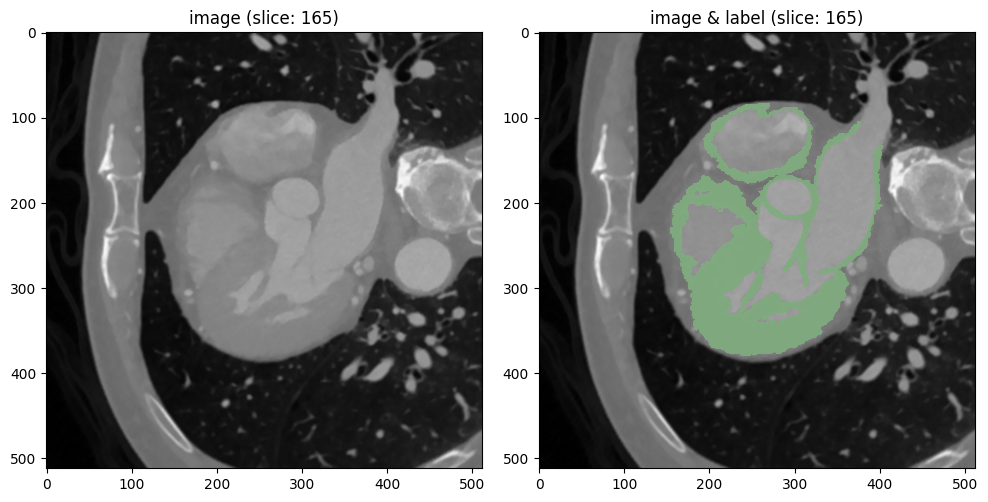

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_30
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_30/pid_30.nii.gz
img shape: [512, 512, 274]
img spacing: [0.3515625, 0.3515625, 0.5]
lbl shape: [512, 512, 274]
lbl spacing: [0.3515625, 0.3515625, 0.5]
lbl ids: [0. 1.]


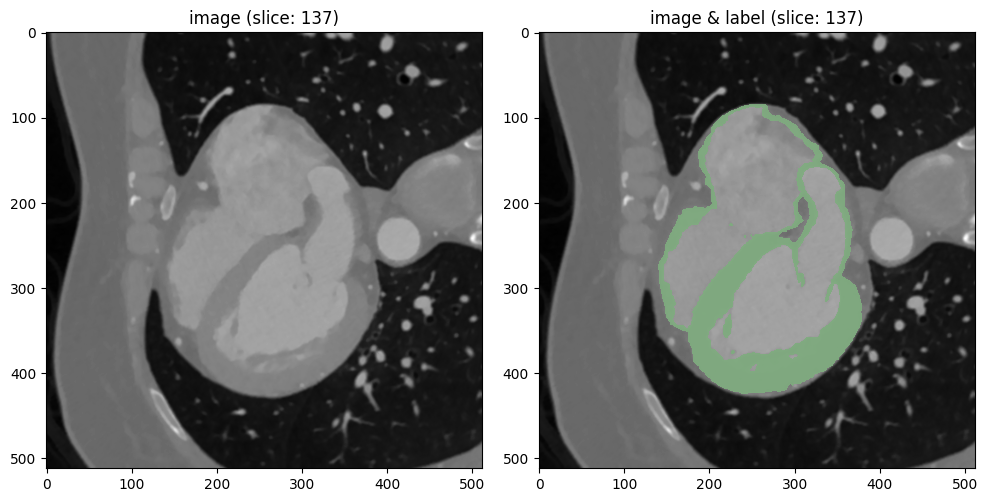

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_52
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_52/pid_52.nii.gz
img shape: [512, 512, 275]
img spacing: [0.34375, 0.34375, 0.5]
lbl shape: [512, 512, 275]
lbl spacing: [0.34375, 0.34375, 0.5]
lbl ids: [0. 1.]


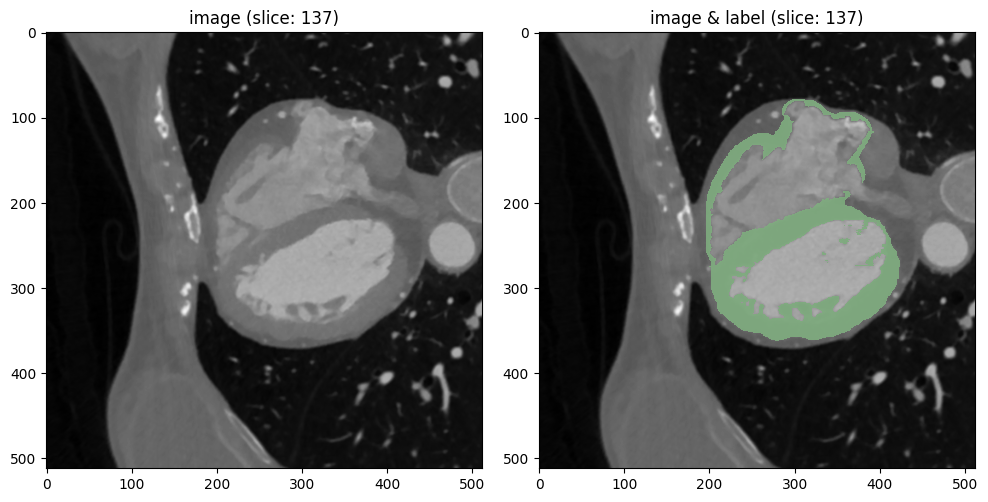

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_56
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_56/pid_56.nii.gz
img shape: [512, 512, 297]
img spacing: [0.36523438, 0.36523438, 0.5]
lbl shape: [512, 512, 297]
lbl spacing: [0.36523438, 0.36523438, 0.5]
lbl ids: [0. 1.]


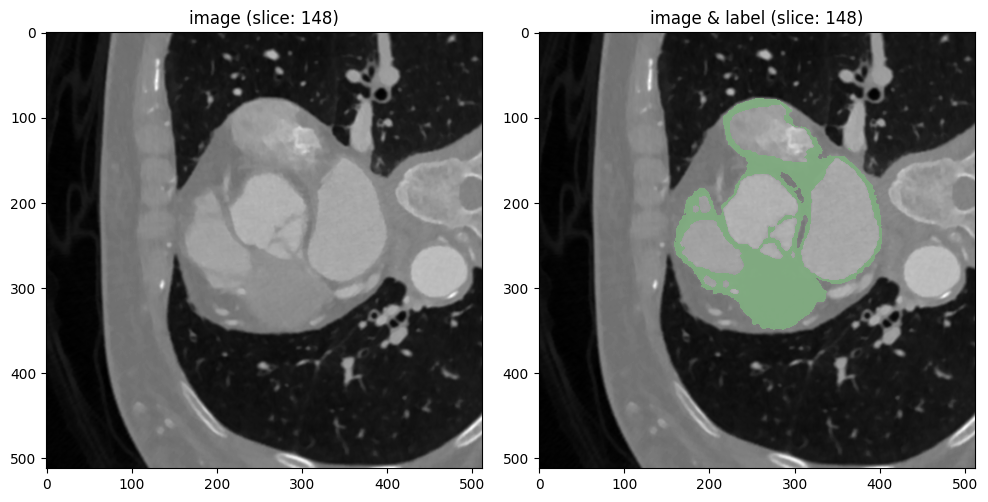

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_57
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_57/pid_57.nii.gz
img shape: [512, 512, 411]
img spacing: [0.47851562, 0.47851562, 0.4]
lbl shape: [512, 512, 411]
lbl spacing: [0.47851562, 0.47851562, 0.4]
lbl ids: [0. 1.]


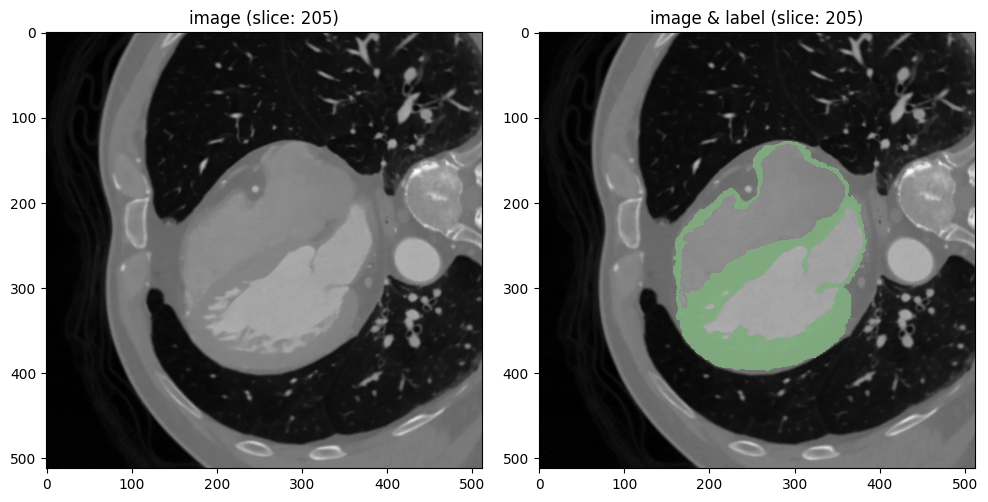

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_110
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_110/pid_110.nii.gz
img shape: [512, 512, 366]
img spacing: [0.37890625, 0.37890625, 0.4]
lbl shape: [512, 512, 366]
lbl spacing: [0.37890625, 0.37890625, 0.4]
lbl ids: [0. 1.]


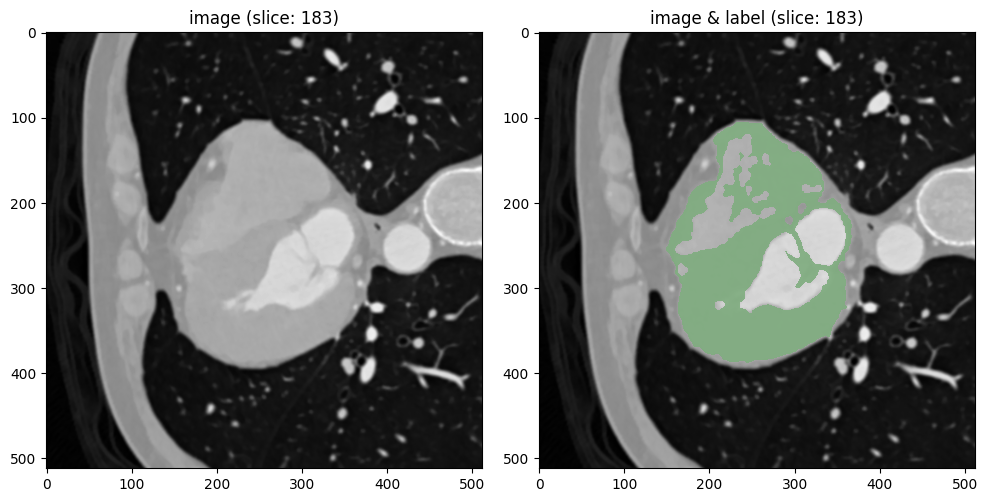

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_1002
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1002/pid_1002.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


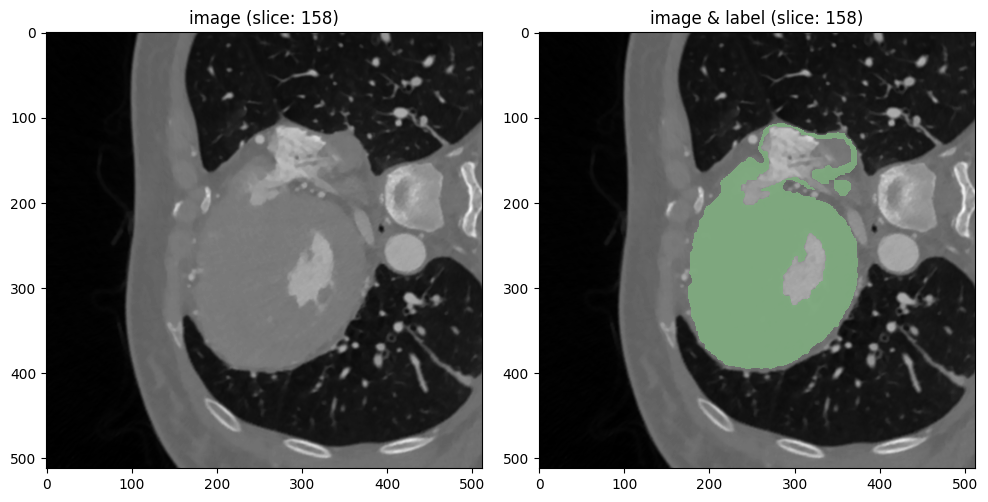

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: pid_1003
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1003/pid_1003.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


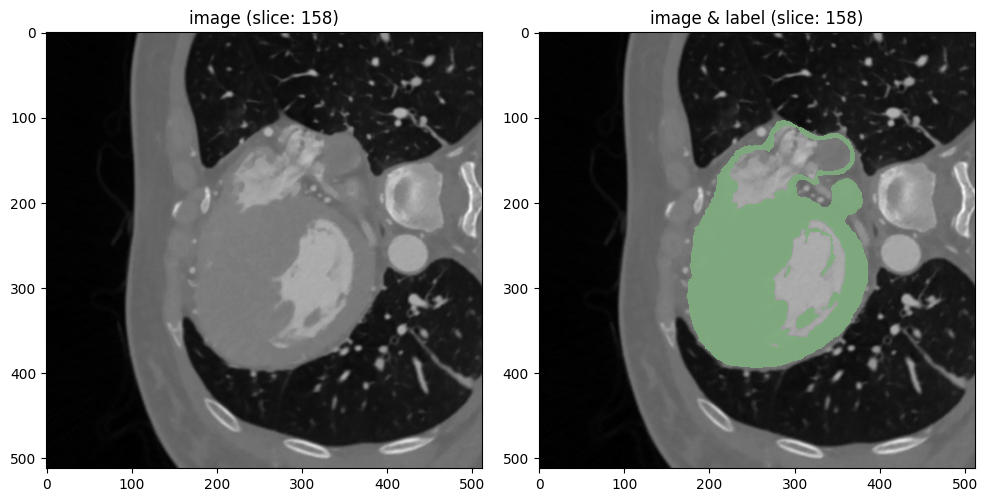

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [73]:
data_info_df = get_data_info(tr_ds)

In [74]:
data_info_df

,pid,img_shape,img_space,lbl_shape,lbl_space,lbl_ids
0,pid_27,"[512, 512, 331]","[0.3828125, 0.3828125, 0.5]","[512, 512, 331]","[0.3828125, 0.3828125, 0.5]","[0.0, 1.0]"
1,pid_30,"[512, 512, 274]","[0.3515625, 0.3515625, 0.5]","[512, 512, 274]","[0.3515625, 0.3515625, 0.5]","[0.0, 1.0]"
2,pid_52,"[512, 512, 275]","[0.34375, 0.34375, 0.5]","[512, 512, 275]","[0.34375, 0.34375, 0.5]","[0.0, 1.0]"
3,pid_56,"[512, 512, 297]","[0.36523438, 0.36523438, 0.5]","[512, 512, 297]","[0.36523438, 0.36523438, 0.5]","[0.0, 1.0]"
4,pid_57,"[512, 512, 411]","[0.47851562, 0.47851562, 0.4]","[512, 512, 411]","[0.47851562, 0.47851562, 0.4]","[0.0, 1.0]"
5,pid_110,"[512, 512, 366]","[0.37890625, 0.37890625, 0.4]","[512, 512, 366]","[0.37890625, 0.37890625, 0.4]","[0.0, 1.0]"
6,pid_1002,"[512, 512, 317]","[0.40625, 0.40625, 0.5]","[512, 512, 317]","[0.40625, 0.40625, 0.5]","[0.0, 1.0]"
7,pid_1003,"[512, 512, 317]","[0.40625, 0.40625, 0.5]","[512, 512, 317]","[0.40625, 0.40625, 0.5]","[0.0, 1.0]"


In [75]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
data_shape_df.mean()

w    512.0
h    512.0
s    323.5
dtype: float64

In [76]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])
data_space_df.mean()

x    0.38916
y    0.38916
z    0.47500
dtype: float32

## Statcics

In [83]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=tr_ds,
    transform=base_tf
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
Loading dataset: 100%|██████████| 8/8 [00:35<00:00,  4.48s/it]


In [84]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile=0.5,max_percentile=99.5)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [85]:
print('data target space:')
data_target_space

data target space:


(0.380859375, 0.380859375, 0.5)

In [86]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', 'min_percentile (0.5%)', 'max_percentile (99.5%)']
)
data_intensities_statcics

data intensities statcics:


,min,med,max,mean,std,min_percentile (0.5%),max_percentile (99.5%)
0,-827.0,117.0,1613.0,130.069946,76.482674,-33.0,454.0


## Transform

In [28]:
space = [1.0,1.0,1.0]
a_min = -42 #s.data_min_percentile
a_max = 423 #s.data_max_percentile
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          SqueezeDimd(keys=["image", "label"]),
          ToTensord(keys=["image", "label"])
      ]
  )

/opt/conda/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/opt/conda/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


pid: pid_27
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_27/pid_27.nii.gz
img shape: [512, 512, 331]
img spacing: [0.3828125, 0.3828125, 0.5]
lbl shape: [512, 512, 331]
lbl spacing: [0.3828125, 0.3828125, 0.5]
lbl ids: [0. 1.]


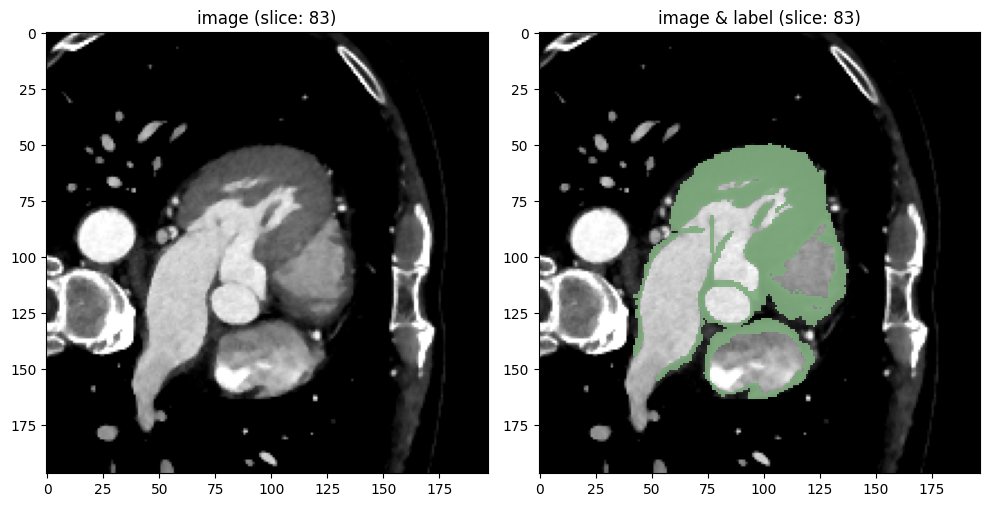

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_30
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_30/pid_30.nii.gz
img shape: [512, 512, 274]
img spacing: [0.3515625, 0.3515625, 0.5]
lbl shape: [512, 512, 274]
lbl spacing: [0.3515625, 0.3515625, 0.5]
lbl ids: [0. 1.]


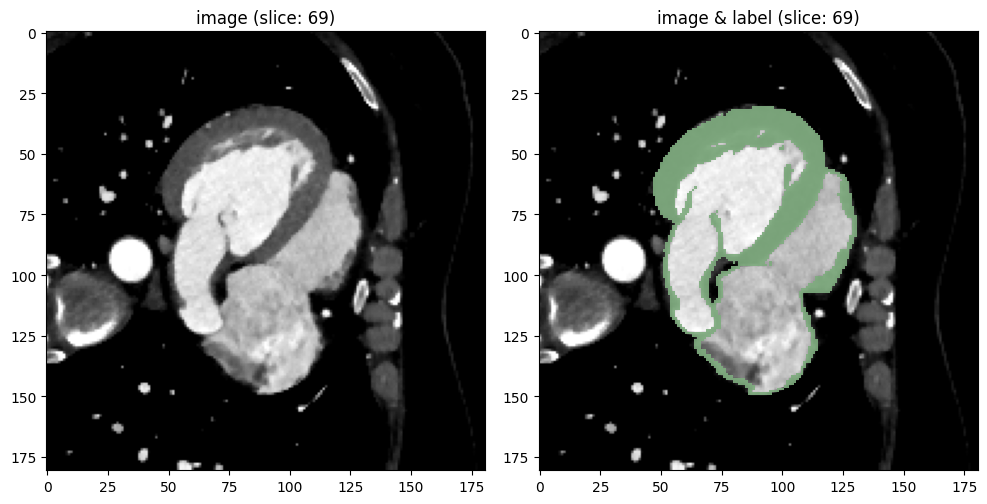

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_57
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_57/pid_57.nii.gz
img shape: [512, 512, 411]
img spacing: [0.47851562, 0.47851562, 0.4]
lbl shape: [512, 512, 411]
lbl spacing: [0.47851562, 0.47851562, 0.4]
lbl ids: [0. 1.]


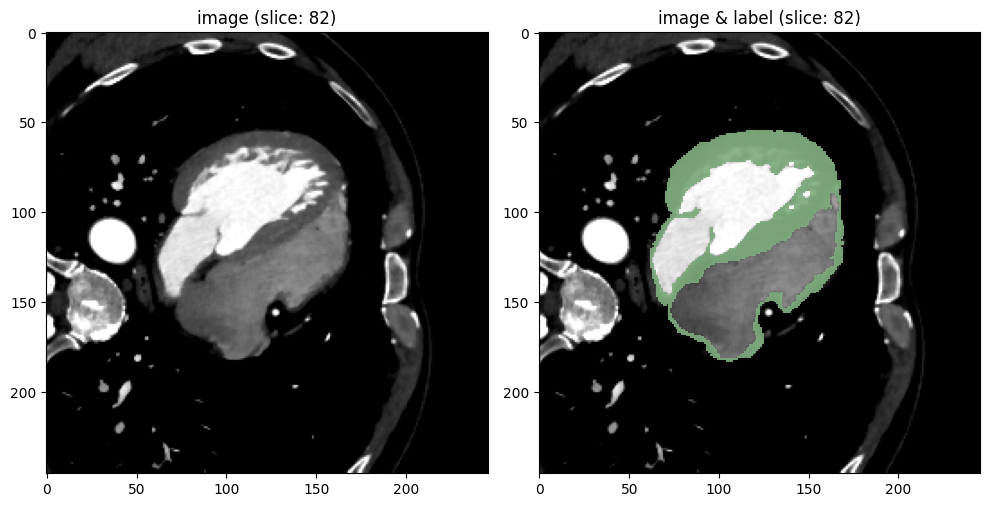

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_110
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_110/pid_110.nii.gz
img shape: [512, 512, 366]
img spacing: [0.37890625, 0.37890625, 0.4]
lbl shape: [512, 512, 366]
lbl spacing: [0.37890625, 0.37890625, 0.4]
lbl ids: [0. 1.]


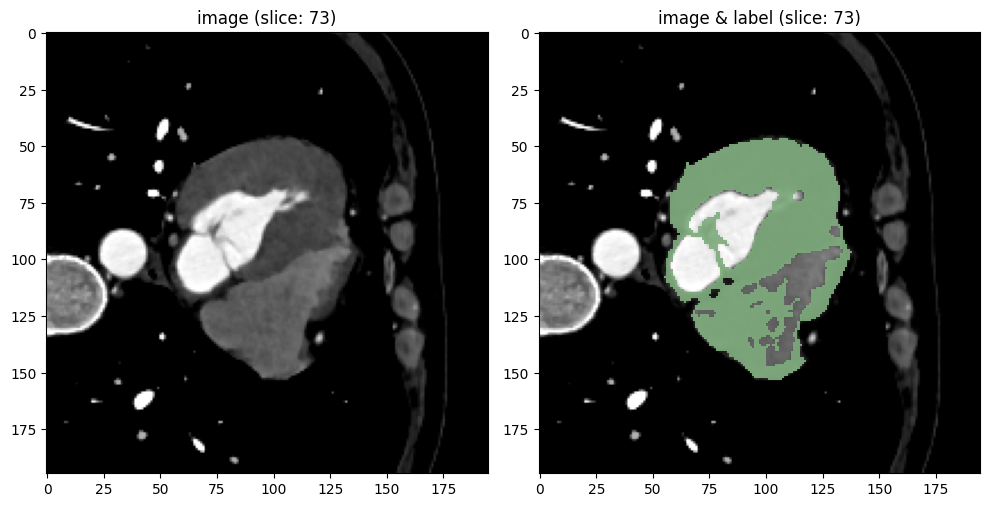

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1002
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1002/pid_1002.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


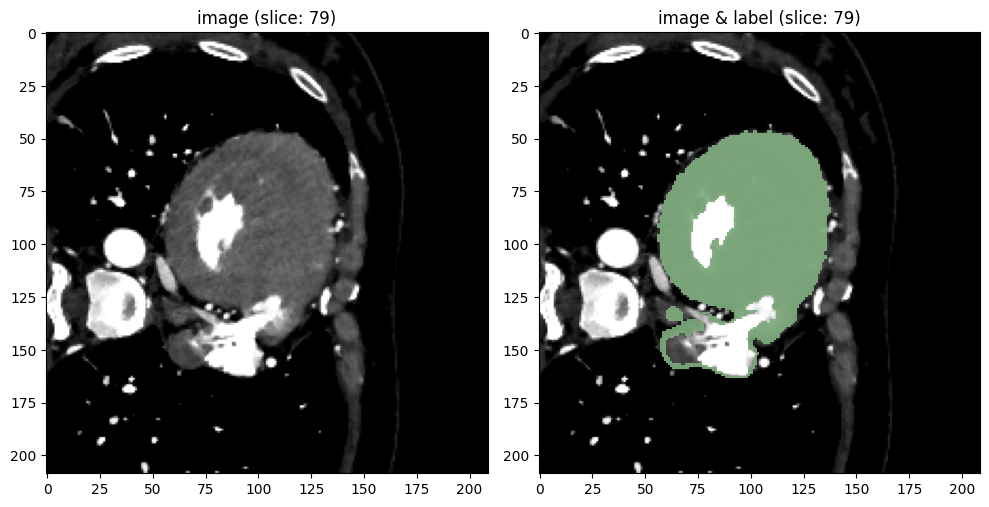

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(



pid: pid_1003
file_pth: /nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1003/pid_1003.nii.gz
img shape: [512, 512, 317]
img spacing: [0.40625, 0.40625, 0.5]
lbl shape: [512, 512, 317]
lbl spacing: [0.40625, 0.40625, 0.5]
lbl ids: [0. 1.]


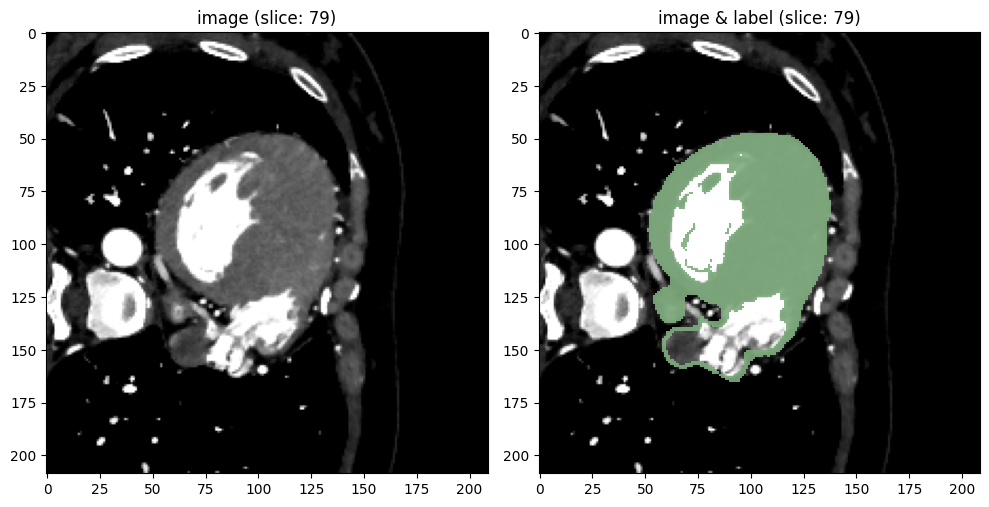

/nfs/Workspace/CardiacSeg/data_utils/utils.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(


In [29]:
data_info_df = get_data_info(tr_ds, transform)